# Logistic Regression with L2 regularization

The goal of this second notebook is to implement your own logistic regression classifier with L2 regularization. You will do the following:

 * Extract features from Amazon product reviews..
 * Write a function to compute the derivative of log likelihood function with an L2 penalty with respect to a single coefficient.
 * Implement gradient ascent with an L2 penalty.
 * Empirically explore how the L2 penalty can ameliorate overfitting.

In [1]:
import pandas as pd
import numpy as np

## Load and process review dataset
For this assignment, we will use the same subset of the Amazon product review dataset that we used in Module 3 assignment. The subset was chosen to contain similar numbers of positive and negative reviews, as the original dataset consisted of mostly positive reviews.

In [2]:
products = pd.read_csv('./amazon_baby_subset.csv')

Just like we did previously, we will work with a hand-curated list of important words extracted from the review data. We will also perform 2 simple data transformations:

1. Remove punctuation using [Python's built-in](https://docs.python.org/2/library/string.html) string functionality.
2. Compute word counts (only for the **important_words**)

Refer to Module 3 assignment for more details.

In [3]:
f = open('important_words.json', 'r')

In [4]:
for line in f:
    important_words = [x.strip().replace('"', '') for x in line.split(",")]

In [5]:
def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text

In [6]:
products = products.fillna({'review':''})

In [7]:
products['review_clean'] = products['review'].str.replace('[^\w\s]','')

In [8]:
for word in important_words:
    products[word] = products['review_clean'].apply(lambda s : s.split().count(word))

In [9]:
products.head()

,name,review,rating,sentiment,review_clean,baby,one,great,love,use,...,seems,picture,completely,wish,buying,babies,won,tub,almost,either
0,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,1,All of my kids have cried nonstop when I tried...,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Nature's Lullabies Second Year Sticker Calendar,We wanted to get something to keep track of ou...,5,1,We wanted to get something to keep track of ou...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Nature's Lullabies Second Year Sticker Calendar,My daughter had her 1st baby over a year ago. ...,5,1,My daughter had her 1st baby over a year ago S...,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Lamaze Peekaboo, I Love You","One of baby's first and favorite books, and it...",4,1,One of babys first and favorite books and it i...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,SoftPlay Peek-A-Boo Where's Elmo A Children's ...,Very cute interactive book! My son loves this ...,5,1,Very cute interactive book My son loves this b...,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0


## Train-Validation split

We split the data into a train-validation split with 80% of the data in the training set and 20% of the data in the validation set. We use `seed=2` so that everyone gets the same result.

**Note:** In previous assignments, we have called this a **train-test split**. However, the portion of data that we don't train on will be used to help **select model parameters**. Thus, this portion of data should be called a **validation set**. Recall that examining performance of various potential models (i.e. models with different parameters) should be on a validation set, while evaluation of selected model should always be on a test set.

In [10]:
train_indices = open('module-4-assignment-train-idx.txt', 'r')
validation_indices = open('module-4-assignment-validation-idx.txt', 'r')
for line in train_indices:
    train_list = [int(x.strip()) for x in line.split(',')]
for line in validation_indices:
    validation_list = [int(x.strip()) for x in line.split(',')]
train_data = products.iloc[train_list]
validation_data = products.iloc[validation_list]

In [11]:
print 'Training set   : %d data points' % len(train_data)
print 'Validation set : %d data points' % len(validation_data)

Training set   : 42361 data points
Validation set : 10711 data points


# Convert data frame to multi-dimensional array

Convert train_data and validation_data into multi-dimensional arrays.

Using the function given in #8 of Module 3 assignment, extract two arrays feature_matrix_train and sentiment_train from train_data. The 2D array feature_matrix_train would contain the content of the columns given by the list important_words. The 1D array sentiment_train would contain the content of the column sentiment. Do the same for validation_data, producing the arrays feature_matrix_valid and sentiment_valid. 

In [12]:
def get_numpy_data(dataframe, features, label):
    dataframe['constant'] = 1
    features = ['constant'] + features
    features_frame = dataframe[features]
    feature_matrix = features_frame.as_matrix()
    label_sarray = dataframe[label]
    label_array = label_sarray.as_matrix()
    return(feature_matrix, label_array)

In [13]:
feature_matrix_train, sentiment_train = get_numpy_data(train_data, important_words, 'sentiment')
feature_matrix_valid, sentiment_valid = get_numpy_data(validation_data, important_words, 'sentiment') 

/Users/jchumley/anaconda/envs/gl-env/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


## Building on logistic regression with no L2 penalty assignment

Let us now build on Module 3 assignment. Recall from lecture that the link function for logistic regression can be defined as:

$$
P(y_i = +1 | \mathbf{x}_i,\mathbf{w}) = \frac{1}{1 + \exp(-\mathbf{w}^T h(\mathbf{x}_i))},
$$

where the feature vector $h(\mathbf{x}_i)$ is given by the word counts of **important_words** in the review $\mathbf{x}_i$. 

We will use the **same code** as in this past assignment to make probability predictions since this part is not affected by the L2 penalty.  (Only the way in which the coefficients are learned is affected by the addition of a regularization term.)

In [14]:
'''
produces probablistic estimate for P(y_i = +1 | x_i, w).
estimate ranges between 0 and 1.
'''
def predict_probability(feature_matrix, coefficients):
    # Take dot product of feature_matrix and coefficients  
    score = np.dot(feature_matrix,coefficients)
    
    # Compute P(y_i = +1 | x_i, w) using the link function
    predictions = 1.0/(1+np.exp(-score))
    
    return predictions

Let us now work on extending logistic regression with L2 regularization. As discussed in the lectures, the L2 regularization is particularly useful in preventing overfitting. In this assignment, we will explore L2 regularization in detail.

Recall from lecture and the previous assignment that for logistic regression without an L2 penalty, the derivative of the log likelihood function is:
$$
\frac{\partial\ell}{\partial w_j} = \sum_{i=1}^N h_j(\mathbf{x}_i)\left(\mathbf{1}[y_i = +1] - P(y_i = +1 | \mathbf{x}_i, \mathbf{w})\right)
$$

** Adding L2 penalty to the derivative** 

It takes only a small modification to add a L2 penalty. All terms indicated in **red** refer to terms that were added due to an **L2 penalty**.

* Recall from the lecture that the link function is still the sigmoid:
$$
P(y_i = +1 | \mathbf{x}_i,\mathbf{w}) = \frac{1}{1 + \exp(-\mathbf{w}^T h(\mathbf{x}_i))},
$$
* We add the L2 penalty term to the per-coefficient derivative of log likelihood:
$$
\frac{\partial\ell}{\partial w_j} = \sum_{i=1}^N h_j(\mathbf{x}_i)\left(\mathbf{1}[y_i = +1] - P(y_i = +1 | \mathbf{x}_i, \mathbf{w})\right) \color{red}{-2\lambda w_j }
$$

The **per-coefficient derivative for logistic regression with an L2 penalty** is as follows:
$$
\frac{\partial\ell}{\partial w_j} = \sum_{i=1}^N h_j(\mathbf{x}_i)\left(\mathbf{1}[y_i = +1] - P(y_i = +1 | \mathbf{x}_i, \mathbf{w})\right) \color{red}{-2\lambda w_j }
$$
and for the intercept term, we have
$$
\frac{\partial\ell}{\partial w_0} = \sum_{i=1}^N h_0(\mathbf{x}_i)\left(\mathbf{1}[y_i = +1] - P(y_i = +1 | \mathbf{x}_i, \mathbf{w})\right)
$$

Write a function that computes the derivative of log likelihood with respect to a single coefficient $w_j$. Unlike its counterpart in the last assignment, the function accepts five arguments:
 * `errors` vector containing $(\mathbf{1}[y_i = +1] - P(y_i = +1 | \mathbf{x}_i, \mathbf{w}))$ for all $i$
 * `feature` vector containing $h_j(\mathbf{x}_i)$  for all $i$
 * `coefficient` containing the current value of coefficient $w_j$.
 * `l2_penalty` representing the L2 penalty constant $\lambda$
 * `feature_is_constant` telling whether the $j$-th feature is constant or not.

In [15]:
def feature_derivative_with_L2(errors, feature, coefficient, l2_penalty, feature_is_constant): 
    
    # Compute the dot product of errors and feature
    derivative = np.sum(np.dot(np.transpose(errors), feature))

    # add L2 penalty term for any feature that isn't the intercept.
    if not feature_is_constant: 
        derivative -= 2*l2_penalty*coefficient
        
    return derivative

** Quiz Question:** In the code above, was the intercept term regularized?

To verify the correctness of the gradient ascent algorithm, we provide a function for computing log likelihood (which we recall from the last assignment was a topic detailed in an advanced optional video, and used here for its numerical stability).

$$\ell\ell(\mathbf{w}) = \sum_{i=1}^N \Big( (\mathbf{1}[y_i = +1] - 1)\mathbf{w}^T h(\mathbf{x}_i) - \ln\left(1 + \exp(-\mathbf{w}^T h(\mathbf{x}_i))\right) \Big) \color{red}{-\lambda\|\mathbf{w}\|_2^2} $$

In [16]:
def compute_log_likelihood_with_L2(feature_matrix, sentiment, coefficients, l2_penalty):
    indicator = (sentiment==+1)
    scores = np.dot(feature_matrix, coefficients)
    
    lp = np.sum((indicator-1)*scores - np.log(1. + np.exp(-scores))) - l2_penalty*np.sum(coefficients[1:]**2)
    
    return lp

** Quiz Question:** Does the term with L2 regularization increase or decrease $\ell\ell(\mathbf{w})$?

The logistic regression function looks almost like the one in the last assignment, with a minor modification to account for the L2 penalty.  Fill in the code below to complete this modification.

In [17]:
def logistic_regression_with_L2(feature_matrix, sentiment, initial_coefficients, step_size, l2_penalty, max_iter):
    coefficients = np.array(initial_coefficients) # make sure it's a numpy array
    for itr in xrange(max_iter):
        # Predict P(y_i = +1|x_i,w) using your predict_probability() function
        predictions = predict_probability(feature_matrix, coefficients)
        
        # Compute indicator value for (y_i = +1)
        indicator = (sentiment==+1)
        # Compute the errors as indicator - predictions
        errors = indicator - predictions
        for j in xrange(len(coefficients)): # loop over each coefficient
            is_intercept = (j == 0)
            # Recall that feature_matrix[:,j] is the feature column associated with coefficients[j].
            # Compute the derivative for coefficients[j]. Save it in a variable called derivative
#             feature_derivative_with_L2(errors, feature, coefficient, l2_penalty, feature_is_constant)
            derivative = feature_derivative_with_L2(errors, feature_matrix[:,j], coefficients[j], l2_penalty, is_intercept)

            # add the step size times the derivative to the current coefficient
            coefficients[j] = coefficients[j] + step_size*derivative
        
        # Checking whether log likelihood is increasing
        if itr <= 15 or (itr <= 100 and itr % 10 == 0) or (itr <= 1000 and itr % 100 == 0) \
        or (itr <= 10000 and itr % 1000 == 0) or itr % 10000 == 0:
            lp = compute_log_likelihood_with_L2(feature_matrix, sentiment, coefficients, l2_penalty)
            print 'iteration %*d: log likelihood of observed labels = %.8f' % \
                (int(np.ceil(np.log10(max_iter))), itr, lp)
    return coefficients

# Explore effects of L2 regularization

Now that we have written up all the pieces needed for regularized logistic regression, let's explore the benefits of using **L2 regularization** in analyzing sentiment for product reviews. **As iterations pass, the log likelihood should increase**.

Below, we train models with increasing amounts of regularization, starting with no L2 penalty, which is equivalent to our previous logistic regression implementation.

In [18]:
# run with L2 = 0
coefficients_0_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                     initial_coefficients=np.zeros(194),
                                                     step_size=5e-6, l2_penalty=0, max_iter=501)

iteration   0: log likelihood of observed labels = -29179.39021798
iteration   1: log likelihood of observed labels = -29003.71035760
iteration   2: log likelihood of observed labels = -28834.65864198
iteration   3: log likelihood of observed labels = -28671.70363804
iteration   4: log likelihood of observed labels = -28514.42569916
iteration   5: log likelihood of observed labels = -28362.47749087
iteration   6: log likelihood of observed labels = -28215.56033041
iteration   7: log likelihood of observed labels = -28073.40981663
iteration   8: log likelihood of observed labels = -27935.78694478
iteration   9: log likelihood of observed labels = -27802.47249034
iteration  10: log likelihood of observed labels = -27673.26336093
iteration  11: log likelihood of observed labels = -27547.97014376
iteration  12: log likelihood of observed labels = -27426.41538599
iteration  13: log likelihood of observed labels = -27308.43232975
iteration  14: log likelihood of observed labels = -27193.8639

In [19]:
# run with L2 = 4
coefficients_4_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                      initial_coefficients=np.zeros(194),
                                                      step_size=5e-6, l2_penalty=4, max_iter=501)

iteration   0: log likelihood of observed labels = -29179.39391674
iteration   1: log likelihood of observed labels = -29003.73193908
iteration   2: log likelihood of observed labels = -28834.71118800
iteration   3: log likelihood of observed labels = -28671.79927422
iteration   4: log likelihood of observed labels = -28514.57569763
iteration   5: log likelihood of observed labels = -28362.69234865
iteration   6: log likelihood of observed labels = -28215.84983345
iteration   7: log likelihood of observed labels = -28073.78309488
iteration   8: log likelihood of observed labels = -27936.25252111
iteration   9: log likelihood of observed labels = -27803.03832495
iteration  10: log likelihood of observed labels = -27673.93689203
iteration  11: log likelihood of observed labels = -27548.75832500
iteration  12: log likelihood of observed labels = -27427.32472103
iteration  13: log likelihood of observed labels = -27309.46890412
iteration  14: log likelihood of observed labels = -27195.0334

In [20]:
# run with L2 = 10
coefficients_10_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                      initial_coefficients=np.zeros(194),
                                                      step_size=5e-6, l2_penalty=10, max_iter=501)

iteration   0: log likelihood of observed labels = -29179.39946486
iteration   1: log likelihood of observed labels = -29003.76430910
iteration   2: log likelihood of observed labels = -28834.78999644
iteration   3: log likelihood of observed labels = -28671.94269968
iteration   4: log likelihood of observed labels = -28514.80063527
iteration   5: log likelihood of observed labels = -28363.01452813
iteration   6: log likelihood of observed labels = -28216.28391523
iteration   7: log likelihood of observed labels = -28074.34275308
iteration   8: log likelihood of observed labels = -27936.95051717
iteration   9: log likelihood of observed labels = -27803.88657442
iteration  10: log likelihood of observed labels = -27674.94652580
iteration  11: log likelihood of observed labels = -27549.93974565
iteration  12: log likelihood of observed labels = -27428.68765477
iteration  13: log likelihood of observed labels = -27311.02244877
iteration  14: log likelihood of observed labels = -27196.7861

In [21]:
# run with L2 = 1e2
coefficients_1e2_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                       initial_coefficients=np.zeros(194),
                                                       step_size=5e-6, l2_penalty=1e2, max_iter=501)

iteration   0: log likelihood of observed labels = -29179.48268675
iteration   1: log likelihood of observed labels = -29004.24954507
iteration   2: log likelihood of observed labels = -28835.97059896
iteration   3: log likelihood of observed labels = -28674.08993801
iteration   4: log likelihood of observed labels = -28518.16606847
iteration   5: log likelihood of observed labels = -28367.83182191
iteration   6: log likelihood of observed labels = -28222.77033027
iteration   7: log likelihood of observed labels = -28082.70042622
iteration   8: log likelihood of observed labels = -27947.36760102
iteration   9: log likelihood of observed labels = -27816.53827051
iteration  10: log likelihood of observed labels = -27689.99603057
iteration  11: log likelihood of observed labels = -27567.53912077
iteration  12: log likelihood of observed labels = -27448.97862909
iteration  13: log likelihood of observed labels = -27334.13715772
iteration  14: log likelihood of observed labels = -27222.8477

In [22]:
# run with L2 = 1e3
coefficients_1e3_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                       initial_coefficients=np.zeros(194),
                                                       step_size=5e-6, l2_penalty=1e3, max_iter=501)

iteration   0: log likelihood of observed labels = -29180.31490563
iteration   1: log likelihood of observed labels = -29009.06956165
iteration   2: log likelihood of observed labels = -28847.62063690
iteration   3: log likelihood of observed labels = -28695.14035650
iteration   4: log likelihood of observed labels = -28550.94573916
iteration   5: log likelihood of observed labels = -28414.45205799
iteration   6: log likelihood of observed labels = -28285.14484537
iteration   7: log likelihood of observed labels = -28162.56265279
iteration   8: log likelihood of observed labels = -28046.28609332
iteration   9: log likelihood of observed labels = -27935.93059883
iteration  10: log likelihood of observed labels = -27831.14140733
iteration  11: log likelihood of observed labels = -27731.58991430
iteration  12: log likelihood of observed labels = -27636.97087875
iteration  13: log likelihood of observed labels = -27547.00018229
iteration  14: log likelihood of observed labels = -27461.4129

In [23]:
# run with L2 = 1e5
coefficients_1e5_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                       initial_coefficients=np.zeros(194),
                                                       step_size=5e-6, l2_penalty=1e5, max_iter=501)

iteration   0: log likelihood of observed labels = -29271.85898298
iteration   1: log likelihood of observed labels = -29271.70949208
iteration   2: log likelihood of observed labels = -29271.65681255
iteration   3: log likelihood of observed labels = -29271.61132176
iteration   4: log likelihood of observed labels = -29271.57022075
iteration   5: log likelihood of observed labels = -29271.53300467
iteration   6: log likelihood of observed labels = -29271.49930278
iteration   7: log likelihood of observed labels = -29271.46878310
iteration   8: log likelihood of observed labels = -29271.44114515
iteration   9: log likelihood of observed labels = -29271.41611682
iteration  10: log likelihood of observed labels = -29271.39345172
iteration  11: log likelihood of observed labels = -29271.37292669
iteration  12: log likelihood of observed labels = -29271.35433968
iteration  13: log likelihood of observed labels = -29271.33750769
iteration  14: log likelihood of observed labels = -29271.3222

## Compare coefficients

We now compare the **coefficients** for each of the models that were trained above. We will create a table of features and learned coefficients associated with each of the different L2 penalty values.

In [24]:
table = pd.DataFrame({'word': ['(intercept)'] + important_words})
def add_coefficients_to_table(coefficients, column_name):
    table[column_name] = coefficients
    return table

In [25]:
add_coefficients_to_table(coefficients_0_penalty, 'coefficients [L2=0]')
add_coefficients_to_table(coefficients_4_penalty, 'coefficients [L2=4]')
add_coefficients_to_table(coefficients_10_penalty, 'coefficients [L2=10]')
add_coefficients_to_table(coefficients_1e2_penalty, 'coefficients [L2=1e2]')
add_coefficients_to_table(coefficients_1e3_penalty, 'coefficients [L2=1e3]')
add_coefficients_to_table(coefficients_1e5_penalty, 'coefficients [L2=1e5]')

,word,coefficients [L2=0],coefficients [L2=4],coefficients [L2=10],coefficients [L2=1e2],coefficients [L2=1e3],coefficients [L2=1e5]
0,(intercept),-0.063729,-0.063130,-0.062243,-0.050427,0.000060,0.011362
1,baby,0.074055,0.073976,0.073859,0.072344,0.059745,0.001784
2,one,0.012740,0.012482,0.012103,0.007235,-0.008766,-0.001827
3,great,0.801614,0.796886,0.789924,0.701416,0.376009,0.008950
4,love,1.058595,1.050897,1.039569,0.896676,0.418361,0.009042
5,use,-0.000098,0.000169,0.000562,0.005487,0.017330,0.000418
6,would,-0.287013,-0.286019,-0.284556,-0.265986,-0.188660,-0.008127
7,like,-0.003356,-0.003414,-0.003500,-0.004613,-0.007037,-0.000827
8,easy,0.984571,0.977613,0.967374,0.838255,0.401908,0.008808
9,little,0.524442,0.521407,0.516939,0.460253,0.251227,0.005941


In [26]:
coefficients_0_penalty_list = list(coefficients_0_penalty[1:]) # exclude intercept
word_coefficient_tuples = [(word, coefficient) for word,coefficient in zip(important_words, coefficients_0_penalty_list)]
word_coefficient_tuples = sorted(word_coefficient_tuples, key=lambda x:x[1], reverse=True)
positive_words_tuples = word_coefficient_tuples[:5]
negative_words_tuples = sorted(word_coefficient_tuples, key=lambda x:x[1], reverse=False)[:5]

In [27]:
positive_words = [tup[0] for tup in positive_words_tuples]
negative_words = [tup[0] for tup in negative_words_tuples]
positive_words

['love', 'loves', 'easy', 'perfect', 'great']

In [28]:
negative_words

['disappointed', 'money', 'return', 'waste', 'returned']

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 6

def make_coefficient_plot(table, positive_words, negative_words, l2_penalty_list):
    cmap_positive = plt.get_cmap('Reds')
    cmap_negative = plt.get_cmap('Blues')
    
    xx = l2_penalty_list
    plt.plot(xx, [0.]*len(xx), '--', lw=1, color='k')
    
    table_positive_words = table[table['word'].isin(positive_words)]
    table_negative_words = table[table['word'].isin(negative_words)]
    del table_positive_words['word']
    del table_negative_words['word']
    
    for i in xrange(len(positive_words)):
        color = cmap_positive(0.8*((i+1)/(len(positive_words)*1.2)+0.15))
        plt.plot(xx, table_positive_words[i:i+1].as_matrix().flatten(),
                 '-', label=positive_words[i], linewidth=4.0, color=color)
        
    for i in xrange(len(negative_words)):
        color = cmap_negative(0.8*((i+1)/(len(negative_words)*1.2)+0.15))
        plt.plot(xx, table_negative_words[i:i+1].as_matrix().flatten(),
                 '-', label=negative_words[i], linewidth=4.0, color=color)
        
    plt.legend(loc='best', ncol=3, prop={'size':16}, columnspacing=0.5)
    plt.axis([1, 1e5, -1, 2])
    plt.title('Coefficient path')
    plt.xlabel('L2 penalty ($\lambda$)')
    plt.ylabel('Coefficient value')
    plt.xscale('log')
    plt.rcParams.update({'font.size': 18})
    plt.tight_layout()

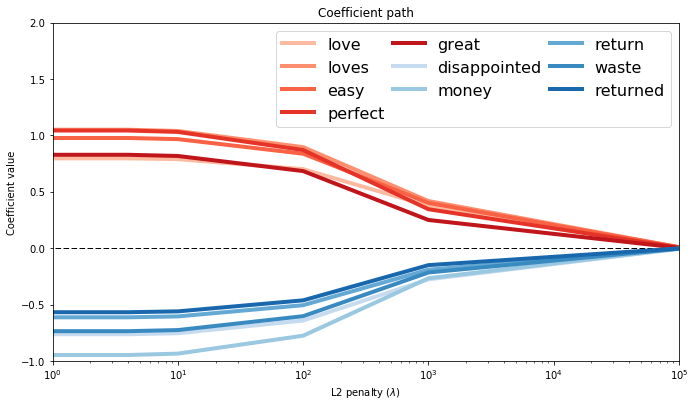

In [30]:
make_coefficient_plot(table, positive_words, negative_words, l2_penalty_list=[0, 4, 10, 1e2, 1e3, 1e5])

**Quiz Question**: (True/False) All coefficients consistently get smaller in size as the L2 penalty is increased.

**Quiz Question**: (True/False) The relative order of coefficients is preserved as the L2 penalty is increased. (For example, if the coefficient for 'cat' was more positive than that for 'dog', this remains true as the L2 penalty increases.)

## Measuring accuracy

Now, let us compute the accuracy of the classifier model. Recall that the accuracy is given by

$$
\mbox{accuracy} = \frac{\mbox{# correctly classified data points}}{\mbox{# total data points}}
$$


Recall from lecture that that the class prediction is calculated using
$$
\hat{y}_i = 
\left\{
\begin{array}{ll}
      +1 & h(\mathbf{x}_i)^T\mathbf{w} > 0 \\
      -1 & h(\mathbf{x}_i)^T\mathbf{w} \leq 0 \\
\end{array} 
\right.
$$

**Note**: It is important to know that the model prediction code doesn't change even with the addition of an L2 penalty. The only thing that changes is the estimated coefficients used in this prediction.

Based on the above, we will use the same code that was used in Module 3 assignment.

In [31]:
def get_classification_accuracy(feature_matrix, sentiment, coefficients):
    scores = np.dot(feature_matrix, coefficients)
    apply_threshold = np.vectorize(lambda x: 1. if x > 0  else -1.)
    predictions = apply_threshold(scores)
    
    num_correct = (predictions == sentiment).sum()
    accuracy = float(num_correct) / len(feature_matrix)  
    return accuracy

Below, we compare the accuracy on the **training data** and **validation data** for all the models that were trained in this assignment.  We first calculate the accuracy values and then build a simple report summarizing the performance for the various models.

In [32]:
train_accuracy = {}
train_accuracy[0]   = get_classification_accuracy(feature_matrix_train, sentiment_train, coefficients_0_penalty)
train_accuracy[4]   = get_classification_accuracy(feature_matrix_train, sentiment_train, coefficients_4_penalty)
train_accuracy[10]  = get_classification_accuracy(feature_matrix_train, sentiment_train, coefficients_10_penalty)
train_accuracy[1e2] = get_classification_accuracy(feature_matrix_train, sentiment_train, coefficients_1e2_penalty)
train_accuracy[1e3] = get_classification_accuracy(feature_matrix_train, sentiment_train, coefficients_1e3_penalty)
train_accuracy[1e5] = get_classification_accuracy(feature_matrix_train, sentiment_train, coefficients_1e5_penalty)

validation_accuracy = {}
validation_accuracy[0]   = get_classification_accuracy(feature_matrix_valid, sentiment_valid, coefficients_0_penalty)
validation_accuracy[4]   = get_classification_accuracy(feature_matrix_valid, sentiment_valid, coefficients_4_penalty)
validation_accuracy[10]  = get_classification_accuracy(feature_matrix_valid, sentiment_valid, coefficients_10_penalty)
validation_accuracy[1e2] = get_classification_accuracy(feature_matrix_valid, sentiment_valid, coefficients_1e2_penalty)
validation_accuracy[1e3] = get_classification_accuracy(feature_matrix_valid, sentiment_valid, coefficients_1e3_penalty)
validation_accuracy[1e5] = get_classification_accuracy(feature_matrix_valid, sentiment_valid, coefficients_1e5_penalty)

In [33]:
# Build a simple report
for key in sorted(validation_accuracy.keys()):
    print "L2 penalty = %g" % key
    print "train accuracy = %s, validation_accuracy = %s" % (train_accuracy[key], validation_accuracy[key])
    print "--------------------------------------------------------------------------------"

L2 penalty = 0
train accuracy = 0.785156157787, validation_accuracy = 0.781346279526
--------------------------------------------------------------------------------
L2 penalty = 4
train accuracy = 0.785108944548, validation_accuracy = 0.781533003454
--------------------------------------------------------------------------------
L2 penalty = 10
train accuracy = 0.784967304832, validation_accuracy = 0.781719727383
--------------------------------------------------------------------------------
L2 penalty = 100
train accuracy = 0.783975826822, validation_accuracy = 0.781066193633
--------------------------------------------------------------------------------
L2 penalty = 1000
train accuracy = 0.775831543165, validation_accuracy = 0.771356549342
--------------------------------------------------------------------------------
L2 penalty = 100000
train accuracy = 0.680342768112, validation_accuracy = 0.667818130893
--------------------------------------------------------------------------